### Importar librerías 

In [1]:
from tools.data_functions import *
from tools.model_factory import ConvBlockConfig, create_model_with_configurations
from tools.custom_callbacks import get_callbacks
import json
import numpy as np
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Definición metodos creación del dataset

In [3]:
dict_map_class = {
    'Loose Silky-bent': 0,
    'Common Chickweed': 1,
    'Scentless Mayweed': 2,
    'Small-flowered Cranesbill': 3,
    'Fat Hen': 4,
    'Charlock': 5,
    'Sugar beet': 6,
    'Cleavers': 7,
    'Black-grass': 8,
    'Shepherds Purse': 9,
    'Common wheat': 10,
    'Maize': 11,   
}

dict_map_class_inverted = {v: k for k, v in dict_map_class.items()}

def get_dict_dataset(
    dataset_path: str = 'dataset'
):
    """
    Creates a dictionary mapping image paths to tuples containing class and partition.

    Args:
        dataset_path (str): Path to the dataset directory. Defaults to 'dataset'.

    Returns:
        dict: A dictionary where keys are image paths and values are tuples (class, partition).
    """

    dict_dataset = {}

    train_classes = os.listdir(os.path.join(dataset_path, 'train'))

    for train_class in train_classes:
        class_path = os.path.join(dataset_path, 'train', train_class)
        train_imgs = os.listdir(class_path)
        
        # Split Train images to a 80% for a Train Split for each class
        for train_img in train_imgs[:int(len(train_imgs)*0.8)]:
            train_img_path = os.path.join(class_path, train_img)
            dict_dataset[train_img_path] = (dict_map_class[train_class], 'Train')

        # Assign the rest 20% to Valid Split for each class
        for valid_img in train_imgs[int(len(train_imgs)*0.8):]:
            valid_img_path = os.path.join(class_path, valid_img)
            dict_dataset[valid_img_path] = (dict_map_class[train_class], 'Valid')

    # Geting Test Images
    test_path = os.path.join(dataset_path, 'test')
    test_imgs = os.listdir(test_path)

    for test_img in test_imgs:
        test_img_path = os.path.join(test_path, test_img)
        dict_dataset[test_img_path] = ("Unkown", 'Test')

    return dict_dataset


def dict2dataframe(
    input_dict: Dict[str, Tuple]
):
    """
    Converts a dictionary to a pandas DataFrame with columns for 'path', 'label', and 'split'.

    Args:
        input_dict (dict): A dictionary where keys are image paths and values are tuples (label, split).

    Returns:
        pd.DataFrame: A DataFrame with columns 'path', 'label', and 'split'.
    """
    df = pd.DataFrame([(key, values[0], values[1]) for key, values in input_dict.items()], columns=['path', 'label', 'split'])

    # Returns shuffled datasets
    return df.sample(frac=1, random_state=42).reset_index(drop=True)


### Creacion TF Datasets

In [4]:
def tf_augmenter():
    """
    Returns a TensorFlow function for data augmentation.

    The returned function applies random transformations to the input images,
    including random flips (up-down and left-right), random brightness adjustments,
    and random contrast adjustments.

    Returns:
        callable: A TensorFlow function that takes a variable number of arguments (tensors)
                  representing the dataset and applies data augmentation to the images.
    """
    @tf.function
    def f(*dataset):
        output= list(dataset)
        image = output[0]
        
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_up_down(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_left_right(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_brightness(image, 0.15)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.7:
            image = tf.image.random_contrast(image, 0.6, 1.4)

        output[0] = image
        return output
    return f


@tf.function
def load_image(*inputs):
    """
    TensorFlow function to load an image using a numpy function.

    Args:
        *inputs: Variable number of input tensors.

    Returns:
        list: A list of output tensors with the loaded image as the first element.
    """
    outputs = list(inputs)
    image = tf.numpy_function(load_image_np, [inputs[0]], tf.float32)
    image.set_shape([None, None, 3])
    outputs[0] = image
    
    return outputs


def load_image_np(path):
    """
    Loads an image from the specified path and convert it to a NumPy array.

    Args:
        path (str): The path to the image file.

    Returns:
        np.ndarray: A NumPy array representing the loaded image in RGB format.
    """
    return np.array(Image.open(path).convert('RGB')).astype(np.float32)


def resize(index=0, resize_to=None):
    """
    Returns a TensorFlow function to resize an image in a dataset.

    Args:
        index (int): Index of the image tensor in the dataset. Defaults to 0.
        resize_to (tuple or list or None): Target size for resizing. If None, no resizing is performed. Defaults to None.

    Returns:
        callable: A TensorFlow function that resizes the image in the dataset.
    """
    def f(*dataset):
        output = list(dataset)
        resized_image = tf.image.resize(dataset[index], resize_to)
        resized_image = tf.cast(resized_image, tf.uint8)
        output[index] = resized_image
        
        return output
    return f


def preprocess_input(index):
    """
    Returns a TensorFlow function to preprocess an image in a dataset.

    Args:
        index (int): Index of the image tensor in the dataset.

    Returns:
        callable: A TensorFlow function that preprocesses the image in the dataset.
    """
    @tf.function
    def f(*dataset):
        output = list(dataset)
        image = dataset[index]
        image = tf.cast(image, tf.float32)
        image = image / 255.
        output[index] = image
        
        return output
    return f

In [5]:
def get_dataset(
    df: pd.DataFrame,
    input_size: Tuple[int, int],
    shuffle: bool = False,
    batch_size: int = None,
    gray_scale: bool = False,
    augmenter: bool = False,
    num_aug: int = None,
    test_set: bool = False
)->tf.data.Dataset:
    """
    Creates a TensorFlow dataset from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing information about the dataset.
        input_size (Tuple[int, int]): Tuple representing the target size for image resizing.
        shuffle (bool): Whether to shuffle the dataset. Defaults to False.
        batch_size (int): Batch size for the dataset. If None, no batching is performed. Defaults to None.
        gray_scale (bool): Whether to convert images to grayscale. Defaults to False.
        augmenter (bool): Whether to apply data augmentation. Defaults to False.
        num_aug (int): Number of augmentations to apply if augmenter is True. Defaults to None.
        test_set (bool): Whether the dataset is a test set. Defaults to False.

    Returns:
        tf.data.Dataset: A TensorFlow dataset prepared based on the provided options.
    """
    # Prints info about labels distribution 
    print('Number of instances per label: ',
          pd.Series(df['label']).value_counts(), sep='\n')
    print('\nPercentaje of instances per label: ',
          pd.Series(df['label']).value_counts().div(pd.Series(df['label']).shape[0]),
          sep='\n')

    names = np.array(df['path'], dtype=str)

    if not test_set:
        labels = np.array(tf.keras.utils.to_categorical(df['label'], num_classes=12))
    else:
        labels = np.ones(len(names))

    data = names, labels

    # Creates a tf dataset from paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(data)

    # Shuffles the entire dataset
    if shuffle:
        print(' > Shuffle')
        dataset = dataset.shuffle(len(names))

    # Loading Images
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Resize to desired size
    dataset = dataset.map(resize(resize_to=input_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Augmentation
    if augmenter:
        print(f' > Augmentamos datos numero {num_aug}')
        if num_aug == 1:
            dataset = dataset.map(tf_augmenter(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Preprocessing input
    dataset = dataset.map(preprocess_input(0), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Converts to gray Scale
    if gray_scale:
        print(' > Escala de grises')
        dataset = dataset.map(lambda *args: (tf.image.rgb_to_grayscale(args[0]), *args[1:]))

    # Prepare batch_size
    if batch_size is not None:
        print(' > Establecemos el batchsize')
        dataset = dataset.batch(batch_size)
    
    # Prefetch to overlap data preprocessing and model execution
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

### Creamos los DataFrames con el contenido de nuestro dataset

In [6]:
dict_dataset = get_dict_dataset()

# Creamos el DataFrame 
df_dataset = dict2dataframe(dict_dataset)
print("Complete Dataset - DataFrame")
df_dataset

Complete Dataset - DataFrame


,path,label,split
0,dataset\train\Scentless Mayweed\8c496e84a.png,2,Train
1,dataset\train\Common wheat\4a56f32c6.png,10,Train
2,dataset\test\99569b224.png,Unkown,Test
3,dataset\train\Black-grass\e0380dff9.png,8,Valid
4,dataset\train\Fat Hen\9708f9c0e.png,4,Train
...,...,...,...
5539,dataset\train\Shepherds Purse\953ced7c6.png,9,Train
5540,dataset\test\8cf909eb3.png,Unkown,Test
5541,dataset\test\98062cd87.png,Unkown,Test
5542,dataset\test\cc3d2a59a.png,Unkown,Test


In [7]:
print("Elements in every label (complete dataset):")
df_dataset['label'].value_counts()

Elements in every label (complete dataset):


Unkown    794
0         654
1         611
2         516
3         496
4         475
5         390
6         385
7         287
8         263
9         231
10        221
11        221
Name: label, dtype: int64

In [8]:
df_dataset_train = df_dataset[df_dataset['split'] == 'Train'].drop(columns=['split'])
print("Dataset - Train:")
df_dataset_train

Dataset - Train:


,path,label
0,dataset\train\Scentless Mayweed\8c496e84a.png,2
1,dataset\train\Common wheat\4a56f32c6.png,10
4,dataset\train\Fat Hen\9708f9c0e.png,4
5,dataset\train\Sugar beet\6d623072a.png,6
8,dataset\train\Small-flowered Cranesbill\869252...,3
...,...,...
5534,dataset\train\Scentless Mayweed\948251df3.png,2
5535,dataset\train\Sugar beet\29a0e6bf9.png,6
5537,dataset\train\Charlock\8b35222d0.png,5
5539,dataset\train\Shepherds Purse\953ced7c6.png,9


In [9]:
print("Elements in every label (Train dataset):")
df_dataset_train['label'].value_counts()

Elements in every label (Train dataset):


0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: label, dtype: int64

In [10]:
df_dataset_valid = df_dataset[df_dataset['split'] == 'Valid'].drop(columns=['split'])
print("Dataset - Valid:")
df_dataset_valid

Dataset - Valid:


,path,label
3,dataset\train\Black-grass\e0380dff9.png,8
10,dataset\train\Scentless Mayweed\d748c7307.png,2
15,dataset\train\Fat Hen\e6b756e98.png,4
22,dataset\train\Small-flowered Cranesbill\ecf58a...,3
24,dataset\train\Charlock\d1b362c43.png,5
...,...,...
5500,dataset\train\Loose Silky-bent\fc2b27fff.png,0
5501,dataset\train\Charlock\fc3e15a2e.png,5
5503,dataset\train\Scentless Mayweed\d1e775b97.png,2
5505,dataset\train\Common Chickweed\f50c8181a.png,1


In [11]:
print("Elements in every label (Valid dataset):")
df_dataset_valid['label'].value_counts()

Elements in every label (Valid dataset):


0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: label, dtype: int64

In [12]:
df_dataset_test = df_dataset[df_dataset['split'] == 'Test'].drop(columns=['split'])
print("Dataset - Test:")
df_dataset_test

Dataset - Test:


,path,label
2,dataset\test\99569b224.png,Unkown
6,dataset\test\d14aa43f3.png,Unkown
7,dataset\test\b47691c08.png,Unkown
12,dataset\test\19fdf19fb.png,Unkown
14,dataset\test\7d4cd07ad.png,Unkown
...,...,...
5526,dataset\test\b30ab4659.png,Unkown
5536,dataset\test\bb1c84bbc.png,Unkown
5540,dataset\test\8cf909eb3.png,Unkown
5541,dataset\test\98062cd87.png,Unkown


In [13]:
print("DISCLAIMER: Test has no labels in Kaggle!!")
print("Elements in every label (Test dataset):")
df_dataset_test['label'].value_counts()

DISCLAIMER: Test has no labels in Kaggle!!
Elements in every label (Test dataset):


Unkown    794
Name: label, dtype: int64

### Visualizamos muestras random del dataset

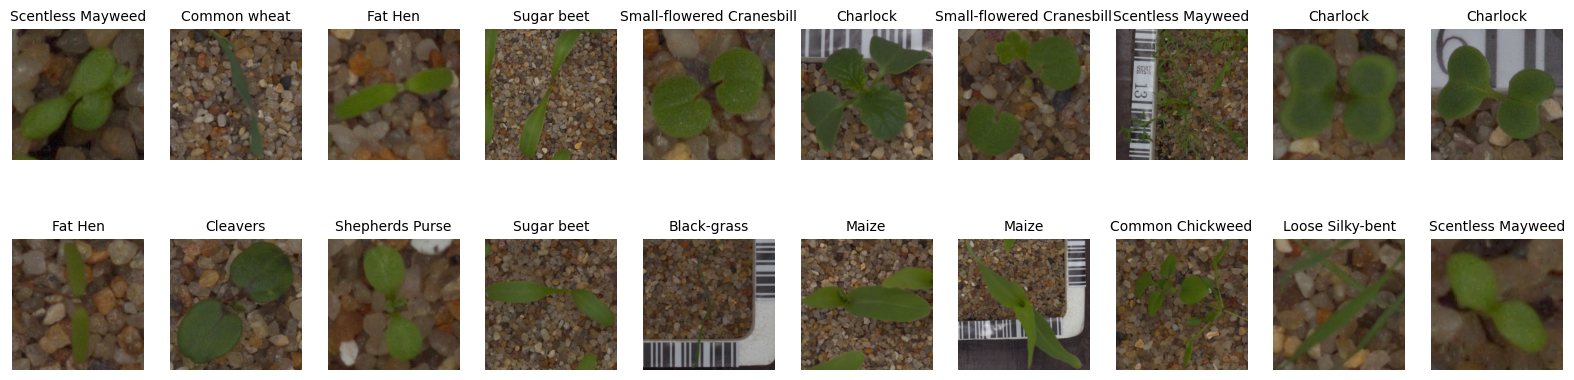

In [14]:
fig = plt.figure(figsize = (20, 5))

for i in range(20):
    img = Image.open(df_dataset_train.iloc[i]['path'])
    ax = fig.add_subplot(2, 10, i + 1)
    ax.imshow(img.convert('RGB'))
    title = dict_map_class_inverted[df_dataset_train.iloc[i]['label']]
    ax.set_title(title, fontsize=10)
    ax.axis('off')

### Creamos los datasets para train, val y test

In [15]:
print("Dataset Train (TensorFlow):")

train_tfdataset = get_dataset(
    df=df_dataset_train,
    input_size=(224,224),
    batch_size=32,
    shuffle=True,
    gray_scale=False,
    augmenter=True,
    num_aug=1,
)
train_tfdataset

Dataset Train (TensorFlow):
Number of instances per label: 
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: label, dtype: int64

Percentaje of instances per label: 
0     0.137849
1     0.128624
2     0.108593
3     0.104375
4     0.100158
5     0.082235
6     0.081181
7     0.060358
8     0.055351
9     0.048498
10    0.046389
11    0.046389
Name: label, dtype: float64
 > Shuffle
 > Augmentamos datos numero 1
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [16]:
print("Dataset Valid (TensorFlow):")

valid_tfdataset = get_dataset(
    df=df_dataset_valid,
    input_size=(224,224),
    batch_size=32,
    shuffle=True,
    gray_scale=False,
    augmenter=False,
)

valid_tfdataset

Dataset Valid (TensorFlow):
Number of instances per label: 
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: label, dtype: int64

Percentaje of instances per label: 
0     0.137029
1     0.128661
2     0.108787
3     0.104603
4     0.099372
5     0.081590
6     0.080544
7     0.060669
8     0.055439
9     0.049163
11    0.047071
10    0.047071
Name: label, dtype: float64
 > Shuffle
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [17]:
print("Dataset Test (TensorFlow):")

test_tfdataset = get_dataset(
    df=df_dataset_test,
    input_size=(224,224),
    batch_size=32,
    gray_scale=False,
    augmenter=False,
    test_set=True,
)

test_tfdataset

Dataset Test (TensorFlow):
Number of instances per label: 
Unkown    794
Name: label, dtype: int64

Percentaje of instances per label: 
Unkown    1.0
Name: label, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Se define la representación de los pesos de cada label en el dataset y el número de labels

In [18]:
# Class weights
computed_class_weights = compute_class_weight(class_weight='balanced', 
                                                classes=np.unique(df_dataset_train['label'].values),
                                                y=df_dataset_train['label'].values)
class_weights = {idx: item for idx, item in enumerate(computed_class_weights)}

print(f"Class Weights per label: {class_weights}")

# Num clases
num_classes = df_dataset_train["label"].max() + 1
print(f"Number classes: {num_classes}")

Class Weights per label: {0: 0.6045251752708731, 1: 0.6478825136612022, 2: 0.7673948220064725, 3: 0.7984006734006734, 4: 0.8320175438596491, 5: 1.0133547008547008, 6: 1.0265151515151516, 7: 1.3806404657933042, 8: 1.5055555555555555, 9: 1.7182971014492754, 10: 1.7964015151515151, 11: 1.7964015151515151}
Number classes: 12


### Funciones Callbacks

In [33]:
from tensorflow.keras.callbacks import Callback

class HistoryAndPlotCallback(Callback):
    def __init__(self, model_name):
        super(HistoryAndPlotCallback, self).__init__()
        self.model_name = model_name

    def on_train_end(self, logs=None):
        # Guardar el historial del modelo
        history = self.model.history.history

        # Calcular límite eje Y
        loss_av = np.average(history["loss"][-1])
        val_loss_av = np.average(history["val_loss"][-1])
        acc_av = np.average(history["accuracy"][-1])
        val_acc_av = np.average(history["val_accuracy"][-1])
        y_upper_limit = np.max([loss_av, val_loss_av, acc_av, val_acc_av])
        y_upper_limit *= 2

        np.save(f'models/{self.model_name}/training_history.npy', history)

        # Guardar métricas y pérdidas en una sola gráfica
        epochs = len(history["loss"])
        
        plt.style.use("ggplot")
        plt.figure(figsize=(12, 8))
        plt.plot(np.arange(0, epochs), history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history["val_accuracy"], label="val_acc")
        
        plt.title(f"Training Loss and Accuracy - {self.model_name}")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc='upper left')
        plt.ylim(0, int(y_upper_limit))
        plt.grid(True)
        
        # Guardar la gráfica
        plt.savefig(f'models/{self.model_name}/training_plot.png')
        plt.close()

        # Guardar history para revisar en el futuro por si se activa un earlystopping o cualquier problema
        pd.DataFrame.from_dict(history).to_csv(f'models/{self.model_name}/history.csv', index=False)


def get_callbacks(model_name):
    callbacks = [
        EarlyStopping(
            monitor = 'val_loss', 
            mode = 'min', 
            patience = 5, 
            verbose=1,
            restore_best_weights=False),
        ModelCheckpoint(
            filepath = f'models/{model_name}',
            monitor = 'val_loss',
            mode = 'min',
            save_best_only = True,
            verbose = 1),
        HistoryAndPlotCallback(model_name),

    ]
        
    return callbacks

### Función para lanzar factoría de modelos from scratch
En este bucle se carga la factoría de modelos from scratch para ir probando cada uno y guardando sus resultados con los callbacks personalizados. Las configuraciones de los modelos vienen desde el archivo "scratch_configs/scratch_experiments.json". Estas configuraciones se pasan a la factoría y se crean los modelos.

In [31]:
def scratch_train(input_shape, experiments_json:str="scratch_configs/scratch_experiments.json"):
    # Cargar configuraciones desde el archivo JSON
    with open(experiments_json, 'r') as file:
        experiment_config = json.load(file)

    # Crear modelo, compilarlo y entrenarlo
    #history_list = []
    for experiment_name, config in experiment_config.items():
        print(f"Running Experiment: {experiment_name}")

        # Configurar el modelo utilizando las configuraciones
        block_configs = []
        for block_conf in config["model"]["conv_block_configs"]:
            block = ConvBlockConfig(block_conf["filters"], 
                                    block_conf["kernel_size"], 
                                    block_conf["use_maxpooling"],
                                    block_conf["use_batchnorm"],
                                    block_conf["dropout_value"],
                                    block_conf["name"])
            block_configs.append(block)
        
        # Crear modelo
        model = create_model_with_configurations(block_configs, input_shape, num_classes)
        
        # Compilar modelo
        model.compile(
            loss = tf.keras.losses.categorical_crossentropy,
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['acc']) 
        
        # Crear callbacks
        callbacks = get_callbacks(experiment_name)

        # Mostrar arquitectura
        print(model.summary())

        # Entrenar modelo
        history = model.fit(train_tfdataset.repeat(),
                            validation_data=valid_tfdataset,
                            class_weight = class_weights,
                            epochs = config["training"]["epochs"],
                            steps_per_epoch=config["training"]["steps_per_epoch"],
                            callbacks = callbacks,
                            verbose=1)
        

        #history_list.append(history)



In [19]:
batch_size = 32

print(len(train_tfdataset)// batch_size)

print(len(valid_tfdataset))

3
30


### Función para modelos pre-entrenados

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, Xception, EfficientNetB2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# Tamaño entrada
input_shape = (224, 224, 3)

# Callbacks y guardado de grádicas
callbacks = get_callbacks("EfficientNetB2")

    
# Cargar el modelo preentrenado de VGG16 sin incluir las capas densas (fully connected)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Crear un nuevo modelo Sequential
model = Sequential()

# Agregar la base preentrenada de VGG16
model.add(base_model)

# Añadir capas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))  

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar la arquitectura del modelo
model.summary()

history = model.fit(
    train_tfdataset.repeat(),
    steps_per_epoch = 32,
    epochs = 50,  # Ajustar según tus necesidades
    validation_data = valid_tfdataset,
    callbacks = callbacks
    )
    


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 flatten_12 (Flatten)        (None, 68992)             0         
                                                                 
 dense_24 (Dense)            (None, 128)               8831104   
                                                                 
 dense_25 (Dense)            (None, 12)                1548      
                                                                 
Total params: 16601221 (63.33 MB)
Trainable params: 8832652 (33.69 MB)
Non-trainable params: 7768569 (29.63 MB)
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 10.45

INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


32/32 [==============================] - 58s 2s/step - loss: 10.4547 - accuracy: 0.0996 - val_loss: 2.4806 - val_accuracy: 0.1370
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.4849 - accuracy: 0.1162
Epoch 2: val_loss did not improve from 2.48057
32/32 [==============================] - 30s 948ms/step - loss: 2.4849 - accuracy: 0.1162 - val_loss: 2.4826 - val_accuracy: 0.1046
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.4805 - accuracy: 0.1230
Epoch 3: val_loss improved from 2.48057 to 2.47894, saving model to models\EfficientNetB2
INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


32/32 [==============================] - 51s 2s/step - loss: 2.4805 - accuracy: 0.1230 - val_loss: 2.4789 - val_accuracy: 0.1370
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 2.4770 - accuracy: 0.1446
Epoch 4: val_loss improved from 2.47894 to 2.47516, saving model to models\EfficientNetB2
INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


32/32 [==============================] - 51s 2s/step - loss: 2.4770 - accuracy: 0.1446 - val_loss: 2.4752 - val_accuracy: 0.1370
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 2.4735 - accuracy: 0.1338
Epoch 5: val_loss improved from 2.47516 to 2.47138, saving model to models\EfficientNetB2
INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


32/32 [==============================] - 50s 2s/step - loss: 2.4735 - accuracy: 0.1338 - val_loss: 2.4714 - val_accuracy: 0.1370
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 2.6135 - accuracy: 0.1445
Epoch 6: val_loss improved from 2.47138 to 2.46771, saving model to models\EfficientNetB2
INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


32/32 [==============================] - 50s 2s/step - loss: 2.6135 - accuracy: 0.1445 - val_loss: 2.4677 - val_accuracy: 0.1370
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 2.4669 - accuracy: 0.1309
Epoch 7: val_loss improved from 2.46771 to 2.46438, saving model to models\EfficientNetB2
INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


INFO:tensorflow:Assets written to: models\EfficientNetB2\assets


32/32 [==============================] - 50s 2s/step - loss: 2.4669 - accuracy: 0.1309 - val_loss: 2.4644 - val_accuracy: 0.1370
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 2.4653 - accuracy: 0.1337

NameError: name 'history' is not defined

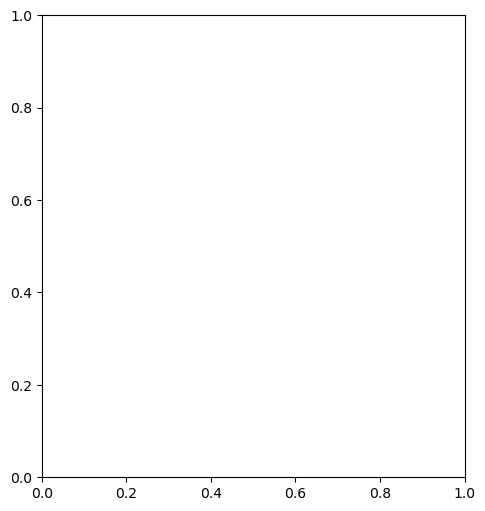

In [29]:
# Mostrar las curvas de entrenamiento
plt.figure(figsize=(12, 6))

# Plot de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Plot de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

# Guardar el modelo
model.save('modelo_entrenado.h5')

In [46]:
# predictions = model.predict(test_tfdataset)


array([[2.27004051e-01, 2.14040116e-03, 8.91496241e-03, ...,
        2.00341688e-03, 1.42939553e-01, 4.43033350e-05],
       [1.93321321e-05, 1.96188036e-03, 2.75497325e-03, ...,
        9.49633960e-03, 1.31269564e-06, 4.49398470e-07],
       [3.47889052e-03, 1.10795826e-01, 3.61276805e-01, ...,
        3.96240242e-02, 5.46889612e-04, 9.38023368e-05],
       ...,
       [1.10524354e-06, 1.16457883e-03, 3.59246158e-03, ...,
        5.33614904e-02, 1.20989853e-05, 1.76579342e-04],
       [1.43219097e-07, 7.91660368e-01, 1.08650071e-03, ...,
        9.82633755e-02, 2.48148335e-05, 7.62169475e-06],
       [7.95045346e-02, 2.08073556e-02, 8.44381601e-02, ...,
        1.18654734e-02, 6.23627715e-02, 1.21713805e-04]], dtype=float32)

### Lanzar entrenamiento from scratch
Usando la configuración de los modelos de la factoría, se lanzan todos los experimentos. De esta manera se ejecutan uno detrás de otro sin necesidad de estar pendiente de lanzarlos manualmente.

In [19]:
# Dimensiones de entrada
input_shape = (224, 224, 3)

# Lanzar entrenamiento
scratch_train(input_shape)

Running Experiment: model1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      2048      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       74368     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       296192    
                                                                 
 top_model_flatten (Flatten  (None, 200704)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               25690240  
                                                                 
 top_model_output (Dense)    (None, 12)                1548      
                           

KeyboardInterrupt: 